In [30]:
import copy
from itertools import tee
import logging
from rdkit import Chem
from rdkit.Chem.rdchem import BondType, BondStereo, BondDir

In [31]:
log = logging.getLogger('tautomer')

BONDMAP = {'-': BondType.SINGLE, '=': BondType.DOUBLE, '#': BondType.TRIPLE, ':': BondType.AROMATIC}
CHARGEMAP = {'+': 1, '0': 0, '-': -1}

tautomer_transforms = [
    {'name': '1,3 (thio)keto/enol f', 'smarts': '[CX4!H0][C]=[O,S,Se,Te;X1]'},
    {'name': '1,3 (thio)keto/enol r', 'smarts': '[O,S,Se,Te;X2!H0][C]=[C]'},
    {'name': '1,5 (thio)keto/enol f', 'smarts': '[CX4,NX3;!H0][C]=[C][CH0]=[O,S,Se,Te;X1]'},
    {'name': '1,5 (thio)keto/enol r', 'smarts': '[O,S,Se,Te;X2!H0][CH0]=,:[C][C]=,:[C,N]'},
    {'name': 'aliphatic imine f', 'smarts': '[CX4!H0][C]=[NX2]'},
    {'name': 'aliphatic imine r', 'smarts': '[NX3!H0][C]=[CX3]'},
    {'name': 'special imine f', 'smarts': '[N!H0][C]=[CX3R0]'},
    {'name': 'special imine r', 'smarts': '[CX4!H0][c]=,:[n]'},
    {'name': '1,3 aromatic heteroatom H shift f', 'smarts': '[#7!H0][#6R1]=[O,#7X2]'},
    {'name': '1,3 aromatic heteroatom H shift r', 'smarts': '[O,#7;!H0][#6R1]=,:[#7X2]'},
    {'name': '1,3 heteroatom H shift', 'smarts': '[#7,S,O,Se,Te;!H0][#7X2,#6,#15]=[#7,#16,#8,Se,Te]'},
    {'name': '1,5 aromatic heteroatom H shift', 'smarts': '[n,s,o;!H0]:[c,n]:[c]:[c,n]:[n,s,o;H0]'},
    {'name': '1,5 aromatic heteroatom H shift f', 'smarts': '[#7,#16,#8,Se,Te;!H0][#6,nX2]=,:[#6,nX2][#6,#7X2]=,:[#7X2,S,O,Se,Te]'},
    {'name': '1,5 aromatic heteroatom H shift r', 'smarts': '[#7,S,O,Se,Te;!H0][#6,#7X2]=,:[#6,nX2][#6,nX2]=,:[#7,#16,#8,Se,Te]'},
    {'name': '1,7 aromatic heteroatom H shift f', 'smarts': '[#7,#8,#16,Se,Te;!H0][#6,#7X2]=,:[#6,#7X2][#6,#7X2]=,:[#6][#6,#7X2]=,:[#7X2,S,O,Se,Te,CX3]'},
    {'name': '1,7 aromatic heteroatom H shift r', 'smarts': '[#7,S,O,Se,Te,CX4;!H0][#6,#7X2]=,:[#6][#6,#7X2]=,:[#6,#7X2][#6,#7X2]=,:[NX2,S,O,Se,Te]'},
    {'name': '1,9 aromatic heteroatom H shift f', 'smarts': '[#7,O;!H0][#6,#7X2]=,:[#6,#7X2][#6,#7X2]=,:[#6,#7X2][#6,#7X2]=,:[#6,#7X2][#6,#7X2]=,:[#7,O]'},
    {'name': '1,11 aromatic heteroatom H shift f', 'smarts': '[#7,O;!H0][#6,nX2]=,:[#6,nX2][#6,nX2]=,:[#6,nX2][#6,nX2]=,:[#6,nX2][#6,nX2]=,:[#6,nX2][#6,nX2]=,:[#7X2,O]'},
    {'name': 'furanone f', 'smarts': '[O,S,N;!H0][#6X3r5;$([#6][!#6])]=,:[#6X3r5]'},
    {'name': 'furanone r', 'smarts': '[#6r5!H0][#6X3r5;$([#6][!#6])]=[O,S,N]'},
    {'name': 'keten/ynol f', 'smarts': '[C!H0]=[C]=[O,S,Se,Te;X1]', 'bonds': '#-'},
    {'name': 'keten/ynol r', 'smarts': '[O,S,Se,Te;!H0X2][C]#[C]', 'bonds': '=='},
    {'name': 'ionic nitro/aci-nitro f', 'smarts': '[C!H0][N+;$([N][O-])]=[O]'},
    {'name': 'ionic nitro/aci-nitro r', 'smarts': '[O!H0][N+;$([N][O-])]=[C]'},
    {'name': 'oxim/nitroso f', 'smarts': '[O!H0][N]=[C]'},
    {'name': 'oxim/nitroso r', 'smarts': '[C!H0][N]=[O]'},
    {'name': 'oxim/nitroso via phenol f', 'smarts': '[O!H0][N]=[C][C]=[C][C]=[OH0]'},
    {'name': 'oxim/nitroso via phenol r', 'smarts': '[O!H0][c]:[c]:[c]:[c][N]=[OH0]'},
    {'name': 'cyano/iso-cyanic acid f', 'smarts': '[O!H0][C]#[N]', 'bonds': '=='},
    {'name': 'cyano/iso-cyanic acid r', 'smarts': '[N!H0]=[C]=[O]', 'bonds': '#-'},
    {'name': 'formamidinesulfinic acid f', 'smarts': '[O,N;!H0][C][S,Se,Te]=[O]', 'bonds': '=--'},
    {'name': 'formamidinesulfinic acid r', 'smarts': '[O!H0][S,Se,Te][C]=[O,N]', 'bonds': '=--'},
    {'name': 'isocyanide f', 'smarts': '[C-0!H0]#[N+0]', 'bonds': '#', 'charges': '-+'},
    {'name': 'isocyanide r', 'smarts': '[N+!H0]#[C-]', 'bonds': '#', 'charges': '-+'},
    {'name': 'phosphonic acid f', 'smarts': '[OH][PH0]', 'bonds': '='},
    {'name': 'phosphonic acid r', 'smarts': '[PH]=[O]', 'bonds': '-'}
]
for transform in tautomer_transforms:
    transform['smarts'] = Chem.MolFromSmarts(transform['smarts'].encode('utf8'))

tautomer_scores = [
    {'name': 'benzoquinone', 'smarts': '[#6]1([#6]=[#6][#6]([#6]=[#6]1)=,:[N,S,O])=,:[N,S,O]', 'score': 25},
    {'name': 'oxim', 'smarts': '[#6]=[N][OH]', 'score': 4},
    {'name': 'C=O', 'smarts': '[#6]=,:[#8]', 'score': 2},
    {'name': 'N=O', 'smarts': '[#7]=,:[#8]', 'score': 2},
    {'name': 'P=O', 'smarts': '[#15]=,:[#8]', 'score': 2},
    {'name': 'C=hetero', 'smarts': '[#6]=[!#1;!#6]', 'score': 1},
    {'name': 'methyl', 'smarts': '[CX4H3]', 'score': 1},
    {'name': 'guanidine terminal=N', 'smarts': '[#7][#6](=[NR0])[#7H0]', 'score': 1},
    {'name': 'guanidine endocyclic=N', 'smarts': '[#7;R][#6;R]([N])=[#7;R]', 'score': 2},
    {'name': 'aci-nitro', 'smarts': '[#6]=[N+]([O-])[OH]', 'score': -4},
]

for tscore in tautomer_scores:
    tscore['smarts'] = Chem.MolFromSmarts(tscore['smarts'])


def canonical_tautomer(mol, max_tautomers=1000):
    """Enumerate all possible tautomers and return a canonical tautomer based on a scoring system.

    :param mol: An RDKit Mol object.
    :param max_tautomers: The maximum number of tautomers to enumerate (limit to prevent combinatorial explosion)
    """
    tautomers = enumerate_tautomers(mol, max_tautomers)
    if len(tautomers) == 1:
        return tautomers[0]
    # Calculate score for each tautomer
    highest = None
    for t in tautomers:
        smiles = Chem.MolToSmiles(t, isomericSmiles=True)
        log.debug('Tautomer: %s', smiles)
        score = 0
        # Add aromatic ring scores
        ssr = Chem.GetSymmSSSR(t)
        for ring in ssr:
            btypes = {t.GetBondBetweenAtoms(*pair).GetBondType() for pair in _pairwise(ring)}
            elements = {t.GetAtomWithIdx(idx).GetAtomicNum() for idx in ring}
            if btypes == {BondType.AROMATIC}:
                log.debug('Score +100 (aromatic ring)')
                score += 100
                if elements == {6}:
                    log.debug('Score +150 (carbocyclic aromatic ring)')
                    score += 150
        # Add SMARTS scores
        for tscore in tautomer_scores:
            for match in t.GetSubstructMatches(tscore['smarts']):
                log.debug('Score %+d (%s)', tscore['score'], tscore['name'])
                score += tscore['score']
        # Add (P,S,Se,Te)-H scores
        for atom in t.GetAtoms():
            if atom.GetAtomicNum() in {15, 16, 34, 52}:
                hs = atom.GetTotalNumHs()
                if hs:
                    log.debug('Score %+d (%s-H bonds)', -hs, atom.GetSymbol())
                    score -= hs
        # Set as highest if score higher or if score equal and smiles comes first alphabetically
        if not highest or highest['score'] < score or (highest['score'] == score and smiles < highest['smiles']):
            log.debug('New highest tautomer: %s (%s)', smiles, score)
            highest = {'smiles': smiles, 'tautomer': t, 'score': score}
    return highest['tautomer']


def enumerate_tautomers(mol, max_tautomers=1000):
    """Enumerate all possible tautomers and return them as a list.

    :param mol: An RDKit Mol object.
    :param max_tautomers: The maximum number of tautomers to enumerate (limit to prevent combinatorial explosion)
    """
    tautomers = {Chem.MolToSmiles(mol, isomericSmiles=True): copy.deepcopy(mol)}
    done = set()
    while len(tautomers) < max_tautomers:
        for tsmiles in sorted(tautomers):
            if tsmiles in done:
                continue
            for transform in tautomer_transforms:
                for match in tautomers[tsmiles].GetSubstructMatches(transform['smarts']):
                    # Adjust hydrogens
                    product = copy.deepcopy(tautomers[tsmiles])
                    first = product.GetAtomWithIdx(match[0])
                    last = product.GetAtomWithIdx(match[-1])
                    first.SetNumExplicitHs(max(0, first.GetNumExplicitHs() - 1))
                    last.SetNumExplicitHs(last.GetTotalNumHs() + 1)
                    # Adjust bond orders
                    for bi, pair in enumerate(_pairwise(match)):
                        if 'bonds' in transform:
                            product.GetBondBetweenAtoms(*pair).SetBondType(BONDMAP[transform['bonds'][bi]])
                        else:
                            product.GetBondBetweenAtoms(*pair).SetBondType(BondType.DOUBLE if bi % 2 == 0 else BondType.SINGLE)
                    # Adjust charges
                    if 'charges' in transform:
                        for ci, idx in enumerate(match):
                            atom = product.GetAtomWithIdx(idx)
                            atom.SetFormalCharge(atom.GetFormalCharge() + CHARGEMAP[transform['charges'][ci]])
                    try:
                        Chem.SanitizeMol(product)
                        smiles = Chem.MolToSmiles(product, isomericSmiles=True)
                        log.debug('Applied rule: %s to %s', transform['name'], tsmiles)
                        if smiles not in tautomers:
                            log.debug('New tautomer produced: %s' % smiles)
                            tautomers[smiles] = product
                        else:
                            log.debug('Previous tautomer produced again: %s' % smiles)
                    except ValueError:
                        log.debug('ValueError')
            done.add(tsmiles)
        if len(tautomers) == len(done):
            break
    else:
        log.warn('Tautomer enumeration stopped at maximum %s', max_tautomers)
    # Clean up stereochemistry
    for tautomer in tautomers.values():
        Chem.AssignStereochemistry(tautomer, force=True, cleanIt=True)
        for bond in tautomer.GetBonds():
            if bond.GetBondType() == BondType.DOUBLE and bond.GetStereo() > BondStereo.STEREOANY:
                begin = bond.GetBeginAtomIdx()
                end = bond.GetEndAtomIdx()
                for othertautomer in tautomers.values():
                    if not othertautomer.GetBondBetweenAtoms(begin, end).GetBondType() == BondType.DOUBLE:
                        neighbours = tautomer.GetAtomWithIdx(begin).GetBonds() + tautomer.GetAtomWithIdx(end).GetBonds()
                        for otherbond in neighbours:
                            if otherbond.GetBondDir() in {BondDir.ENDUPRIGHT, BondDir.ENDDOWNRIGHT}:
                                otherbond.SetBondDir(BondDir.NONE)
                        Chem.AssignStereochemistry(tautomer, force=True, cleanIt=True)
                        log.debug('Removed stereochemistry from unfixed double bond')
                        break
    return tautomers.values()


def _pairwise(iterable):
    """Utility function to iterate in a pairwise fashion."""
    a, b = tee(iterable)
    next(b, None)
    return zip(a, b)

In [86]:
mols = []
with open('acidity_data.smi') as f:
    for line in f:
        mols.append(line)
        
mols = [Chem.MolFromSmiles(smiles) for smiles in mols]

mols = [i for i in mols if i]

In [68]:
suppl = Chem.SDMolSupplier('acidity_data.sdf')
mols = [x for x in suppl if x]
len(mols)

662

In [88]:
tautomers = []
for n, mol in enumerate(mols):
    #mol = Chem.MolFromSmiles(smiles)
    Chem.SanitizeMol(mol)
    tautomers.append(list(enumerate_tautomers(mol)))

In [89]:
t_len = [len(i) for i in tautomers]

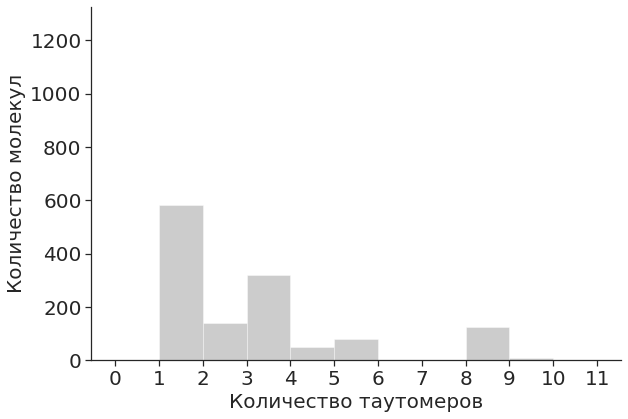

In [119]:
import numpy as np
import seaborn as sns

bins = [i for i in range(12)]

sns.set(rc={'figure.figsize':(9.5, 6.5)})
sns.set_style('white')
sns.set_style("ticks")

hist = sns.distplot(t_len, kde=False, color='grey', bins=bins)

hist.set_ylabel('Количество молекул', fontsize=20)
hist.set_xlabel('Количество таутомеров', fontsize=20)

hist.set_xticks(bins)
#hist.set_yticks(np.linspace(0, 100, 11))

hist.tick_params(labelsize=20)

hist.set_ylim([0, len(tautomers)])

sns.despine()

fig = hist.get_figure()
#fig.savefig('Tautos.png', dpi=750) 

In [25]:
from CGRtools.files.SDFrw import SDFread, SDFwrite

mols = SDFread('acidity.sdf', remap=False).read()

for i, mol in enumerate(mols):
    pka = mol.meta['pKa']
    temp = round(1/float(mol.meta['temperature-K']), 2)
    solv = mol.meta['additive.1']
    amount = mol.meta['amount.1']
    
    mol.meta.clear()
    
    mol.meta['tabulated_constant'] = pka
    mol.meta['temperature'] = temp
    mol.meta['solvent'] = solv
    mol.meta['amount'] = amount
    
fw = SDFwrite('acidity_data.sdf')

for i in mols:
    fw.write(i)